# Hodographs
Ty Janoski

## Setup

In [1]:
# Import statements
from typing import List

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scienceplots  # noqa: F401
import xarray as xr
from matplotlib.patches import Rectangle
from metpy.plots import Hodograph
from scipy.interpolate import interp1d

# Set default style to dark background because I like it better
plt.style.use(["science", "nature"])
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def calculate_layer_mean_wind(u, v, z, z_min=0, z_max=6000):
    mask = (z.values < z_max) & (z_min < z.values)
    u_masked = u[mask]
    v_masked = v[mask]
    z_masked = z[mask]

    if int(mask.sum()) > 1:
        # Calculate the thickness of each layer (difference in adjacent heights)
        layer_thickness = np.diff(z_masked)
        layer_thickness = np.append(
            layer_thickness, layer_thickness[-1]
        )  # Assume last layer has same thickness

        # Calculate weighted means for u and v components
        layer_mean_u = np.average(u_masked, weights=layer_thickness)
        layer_mean_v = np.average(v_masked, weights=layer_thickness)
    elif int(mask.sum() == 1):
        layer_mean_u = u_masked.values[0]
        layer_mean_v = v_masked.values[0]
    elif int(mask.sum() == 0):
        # If no values between 5500 and 6000, interpolate
        fu = interp1d(z, u, kind="linear", fill_value="extrapolate")
        fv = interp1d(z, v, kind="linear", fill_value="extrapolate")
        layer_mean_u = fu(z_max - 250)
        layer_mean_v = fv(z_max - 250)

    return np.array((layer_mean_u, layer_mean_v))


# Make function to calculate shear vector
def calculate_shear_vector(
    u: xr.DataArray, v: xr.DataArray, z: xr.DataArray, z0=0, z1=6000
) -> npt.NDArray[np.float64]:
    # Calculate the 0-500m mean wind
    bottom = calculate_layer_mean_wind(u, v, z, z_min=z0, z_max=z0 + 500)

    # The 5.5-6km mean wind
    top = calculate_layer_mean_wind(u, v, z, z_min=z1 - 500, z_max=z1)

    # Shear is the difference between the two
    shear = top - bottom

    return shear


# Calculate Bunkers right-mover storm motion vector
def calculate_bunker_rm(
    mean: npt.NDArray[np.float64], shear: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    # rotate the shear by 90 deg clockwise for right mover and normalize
    ortho_vec = np.array((shear[1], shear[0] * -1)) / np.linalg.norm(shear)

    # multiply by 7.5 and add to mean wind
    b_rm = mean + 7.5 * ortho_vec
    return b_rm


In [3]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20, 24, 1)]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

lat_coarse = (
    wofs_all[0]
    .xlat_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)
lon_coarse = (
    wofs_all[0]
    .xlon_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)


/tmp/ipykernel_3896054/209570099.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3896054/209570099.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3896054/209570099.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3896054/209570099.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


In [4]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]

# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

# Select wet and dry members
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


In [7]:
# Save out indicies of wet and dry members
xr.concat(ne_wet, dim=init).to_netcdf(
    "data/wet_ensemble.nc",
    mode="w",
    format="NETCDF4",
    unlimited_dims=["init"],
)
xr.concat(ne_dry, dim=init).to_netcdf(
    "data/dry_ensemble.nc",
    mode="w",
    format="NETCDF4",
    unlimited_dims=["init"],
)


In [8]:
u_wet = (
    get_field(
        wofs_wet, "u", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)
v_wet = (
    get_field(
        wofs_wet, "v", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)
z_wet = (
    get_field(
        wofs_wet, "z_agl", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)

u_dry = (
    get_field(
        wofs_dry, "u", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)
v_dry = (
    get_field(
        wofs_dry, "v", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)
z_dry = (
    get_field(
        wofs_dry, "z_agl", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init_dim=init
    )
    .squeeze()
    .mean(dim=("init", "ne"))
)


In [9]:
# specify northern lat/lon
lat, lon = 40.5, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(inds["nx"]), int(inds["ny"])


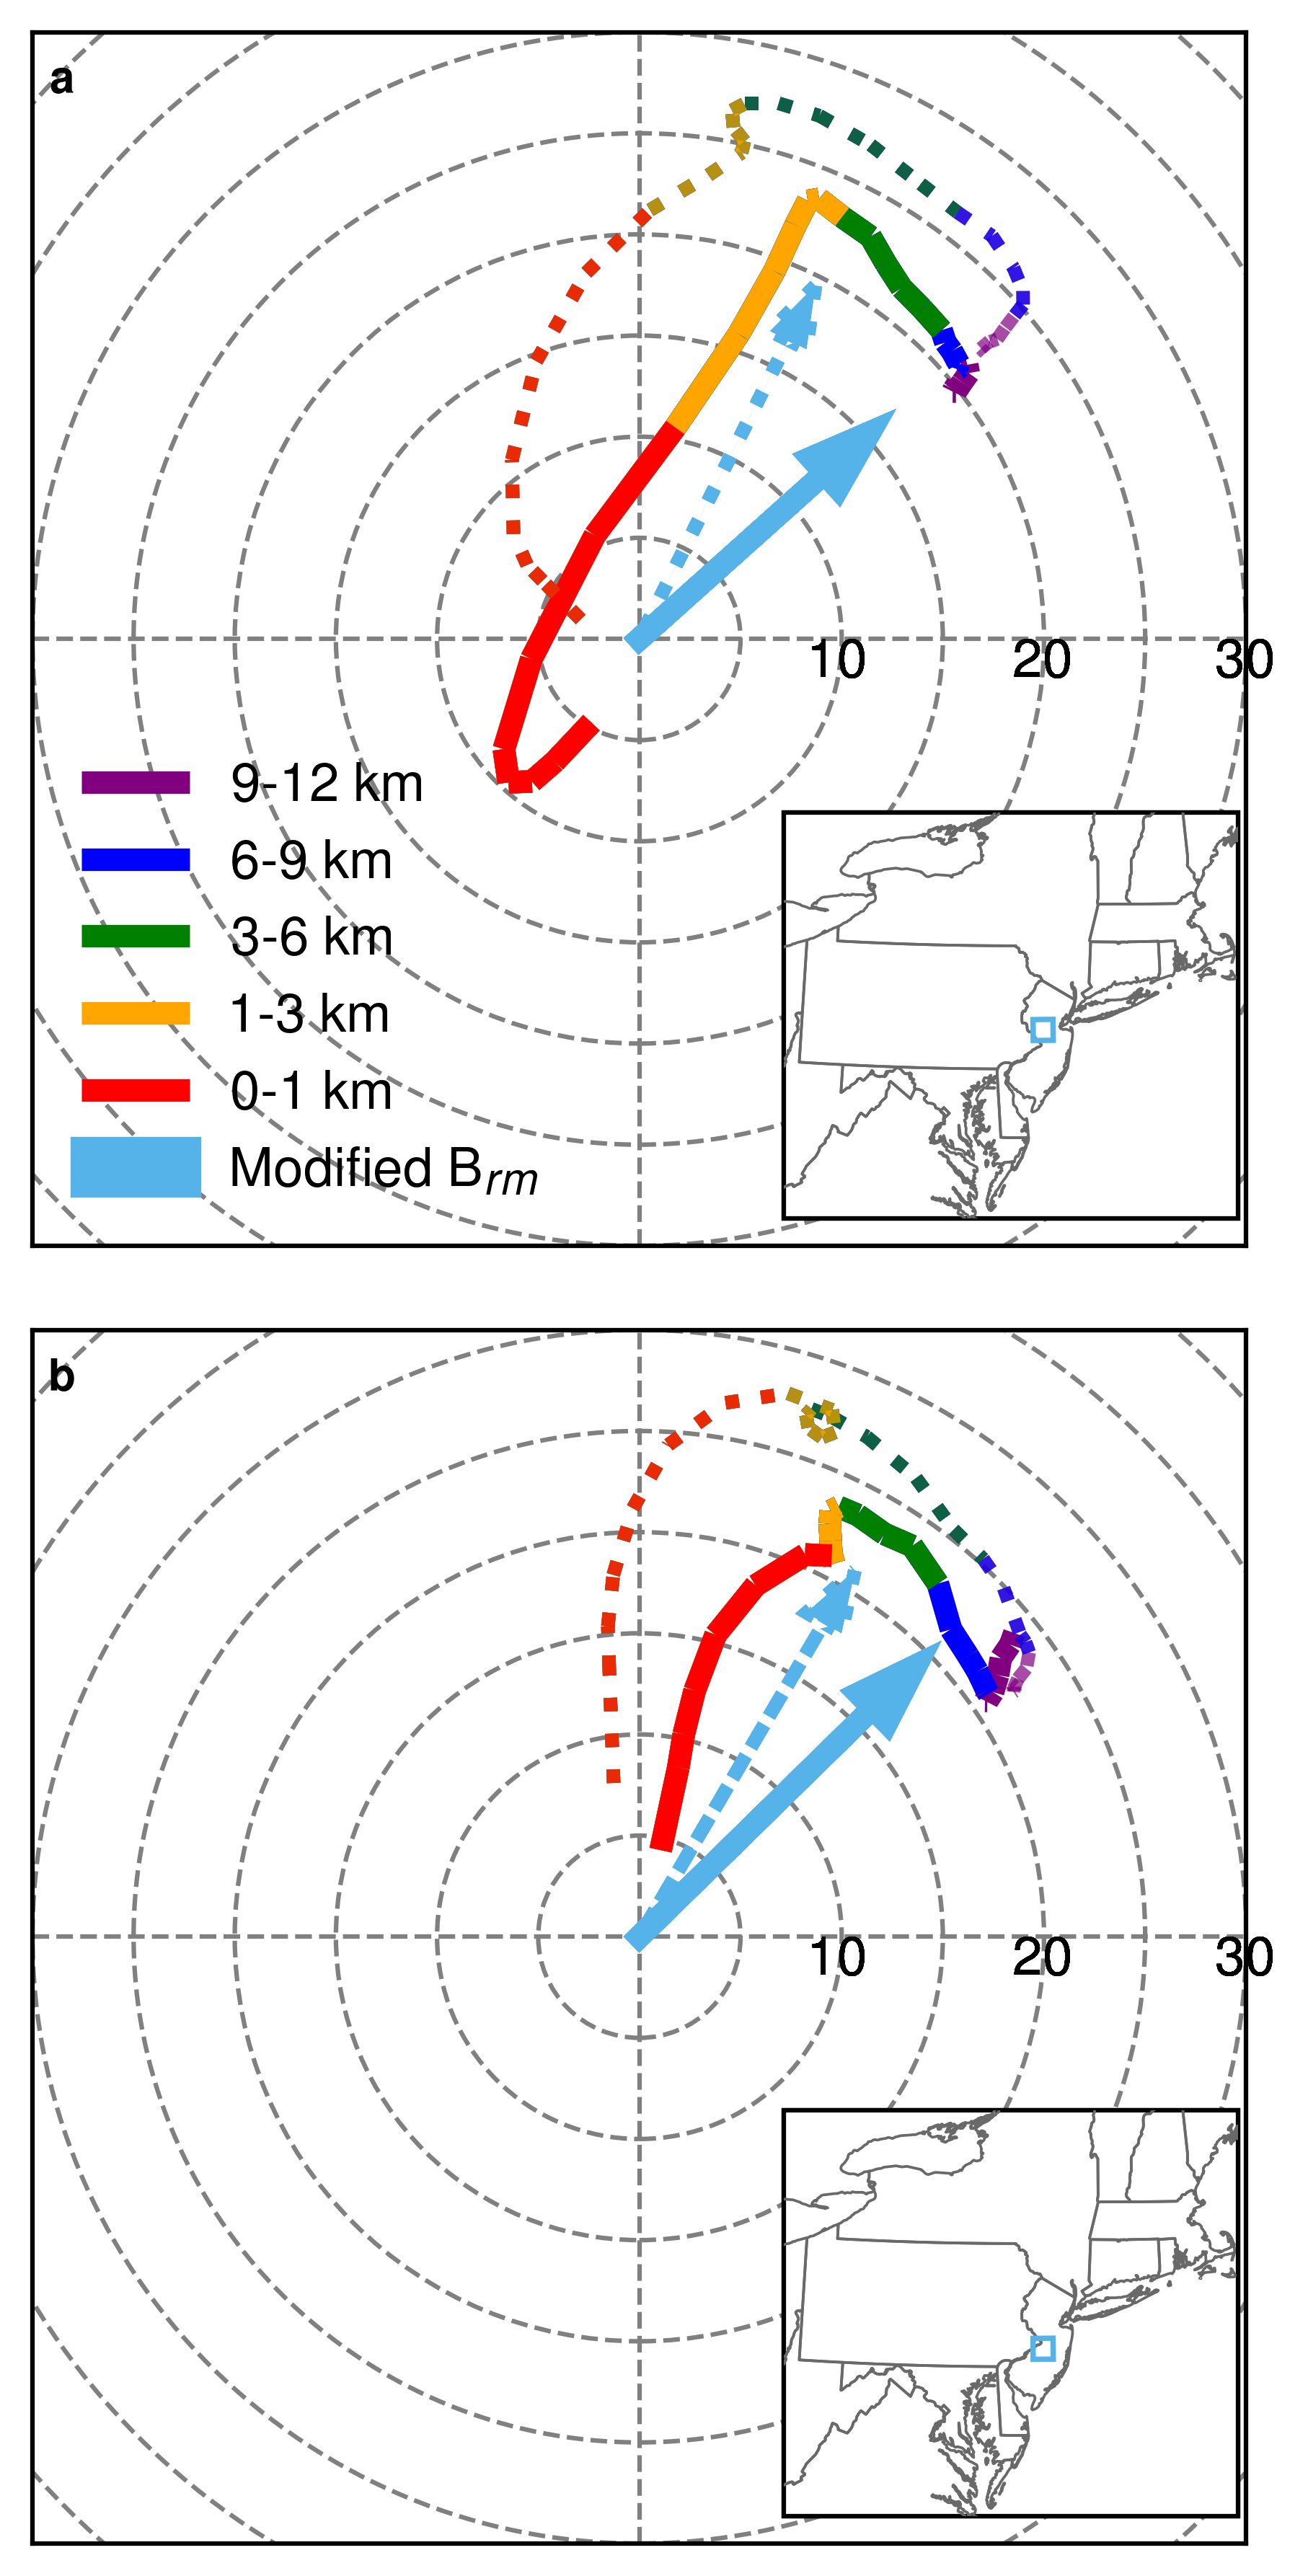

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(2, 4), dpi=900, layout="constrained")

# Define height ranges in meters and corresponding colors
height_ranges = [
    (9000, 12000, "purple", "9-12 km"),
    (6000, 9000, "blue", "6-9 km"),
    (3000, 6000, "green", "3-6 km"),
    (1000, 3000, "orange", "1-3 km"),
    (0, 1000, "red", "0-1 km"),
]

mean_us = [u_wet, u_dry]
mean_vs = [v_wet, v_dry]
mean_zs = [z_wet, z_dry]

letters = ["a", "b"]

for i, ax in enumerate(axes):
    # Create hodograph
    hodograph = Hodograph(ax, component_range=30)
    hodograph.add_grid(increment=5, linewidth=0.5)

    # Flag to ensure the arrow label is added only once
    arrow_label_added = False

    for j in range(2):
        # j=0 -> wet
        # j=1 -> dry
        mean_u = mean_us[j].sel(nx=nx_ind - i, ny=ny_ind).compute()
        mean_v = mean_vs[j].sel(nx=nx_ind - i, ny=ny_ind).compute()
        mean_z = mean_zs[j].sel(nx=nx_ind - i, ny=ny_ind).compute()

        # Set styling based on j
        linestyle = "dotted" if j == 1 else "solid"
        alpha = 0.7 if j == 1 else 1.0
        linewidth = 1.5 if j == 1 else 2.5

        # Plot the mean hodograph by height ranges
        for z_min, z_max, color, label in height_ranges:
            height_mask = mean_z.values < z_max
            hodograph.plot_colormapped(
                mean_u[height_mask],
                mean_v[height_mask],
                mean_v[height_mask],
                color=color,
                label=label if j == 0 else None,
                linestyle=linestyle,
                alpha=alpha,
                linewidth=linewidth,
            )

            # Calculate and plot the layer mean wind (0-4km)
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u, mean_v, mean_z, z_min=0, z_max=4000
            )

            # Calculate shear
            shear = calculate_shear_vector(mean_u, mean_v, mean_z, z0=0, z1=4000)

            # Calculate modified-Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )

            # Plot as arrow
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="#56b3e9",
                head_width=2,
                head_length=3,
                length_includes_head=True,
                zorder=5,
                label=r"Modified B$_{rm}$"
                if not arrow_label_added
                else None,  # Add label only once
                linestyle=linestyle,
                alpha=alpha,
                linewidth=linewidth,
            )

            # Mark that the arrow label has been added
            arrow_label_added = True

            # Add circle labels at 10, 20, 30
            circle_labels = np.arange(10, 40, 10)
            for label in circle_labels:
                ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")

            # Remove the axis labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")

            # Add legend to the first subplot only
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()

                # Move the arrow label to the end
                arrow_handle = handles.pop(labels.index(r"Modified B$_{rm}$"))
                arrow_label = labels.pop(labels.index(r"Modified B$_{rm}$"))
                handles.append(arrow_handle)
                labels.append(arrow_label)

                ax.legend(handles, labels, fontsize=6, loc="lower left")

    ax.text(
        0.015, 0.95, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )

    # Add the map on the right side
    ax_map = fig.add_axes([0.6, 0.18, 0.35, 0.85], projection=proj) # type: ignore
    # Add state boundaries
    ax_map.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="dimgray", zorder=3) # type: ignore

    # Set the extent of the map to focus on the region of interest
    ax_map.set_extent( # type: ignore
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add red boxes over the grid boxes of interest for both wet and dry ensembles
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid

    # South ensemble box
    rect_wet = Rectangle(
        (
            lon_coarse[nx_ind, ny_ind] - box_width / 2,
            lat_coarse[nx_ind, ny_ind] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="#56b3e9",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=4,
    )
    ax_map.add_patch(rect_wet)

    # Add the map on the right side
    ax_map = fig.add_axes([0.6, -0.32, 0.35, 0.85], projection=proj) # type: ignore
    # Add state boundaries
    ax_map.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="dimgray", zorder=3) # type: ignore

    # Set the extent of the map to focus on the region of interest
    ax_map.set_extent( # type: ignore
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add red boxes over the grid boxes of interest for both wet and dry ensembles
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid

    # South ensemble box
    rect_wet = Rectangle(
        (
            lon_coarse[nx_ind - 1, ny_ind] - box_width / 2,
            lat_coarse[nx_ind - 1, ny_ind] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="#56b3e9",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=4,
    )
    ax_map.add_patch(rect_wet)

    # Save fig
    plt.savefig("figures/Fig11_hodograph.pdf",bbox_inches="tight")
